In [130]:
import json
import os
import re
import sqlite3
from datetime import datetime
from typing import Annotated, Literal, TypedDict

import dotenv
import pandas as pd
import psycopg2
from langchain.tools import tool
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field

dotenv.load_dotenv()
API_KEY = os.getenv("OPENROUTER_API_KEY")
BASE_URL = os.getenv("API_BASE_URL")
# MODEL_NAME = os.getenv("MODEL_NAME")

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "user_db",
    "user": "user",
    "password": "user",
}

## Поднимаем локальную БД

In [119]:
llm = ChatOpenAI(model="qwen/qwen3-coder-30b-a3b-instruct", base_url=BASE_URL, api_key=API_KEY)

## Prompts

In [142]:
ROUTER_PROMPT_TEMPLATE = """
Определи, требует ли задача декомпозиции на подзадачи. Кратко объясни свое решение.

**ЗАДАЧА:** {initial_task}

**DDL схема БД:**
```sql
{ddl_schema}
```

**КРИТЕРИИ:**
- Декомпозиция нужна: если требуется >1 независимых запросов или есть сложные зависимости между запросами
- Декомпозиция НЕ нужна: если один запрос с JOIN/GROUP BY решает задачу

**ПРИМЕРЫ:**
- "Сколько пациентов в районе?" → false (1 запрос)
- "Топ-5 районов по обращениям" → false (1 запрос с GROUP BY)
- "Какие классы болезней в топ-5 районах?" → true (сначала топ-5 районов, потом для каждого анализ)
"""

DDL_SCHEMA = """
-- Таблица пациентов
CREATE TABLE IF NOT EXISTS patients (
    id_patient INTEGER PRIMARY KEY, -- Идентификатор пациента
    birth_date DATE, -- Дата рождения пациента
    gender VARCHAR(10), -- Пол пациента
    residential_area VARCHAR(100), -- Район проживания пациента
    region VARCHAR(100) -- Регион проживания пациента
);

-- Таблица диагнозов
CREATE TABLE IF NOT EXISTS diagnoses (
    diagnosis_code VARCHAR(20) PRIMARY KEY, -- МКБ код диагноза
    name VARCHAR(100), -- Название диагноза
    classification VARCHAR(100) -- Классификация диагноза
);

-- Таблица медикаментов
CREATE TABLE IF NOT EXISTS medication (
    medication_code INTEGER PRIMARY KEY, -- Код препарата
    dosage VARCHAR(100), -- Дозировка препарата
    trade_name VARCHAR(100), -- Торговое наименование препарата
    price FLOAT, -- Цена препарата
    info VARCHAR(300) -- Дополнительная информация о препарате
);

-- Таблица рецептов
CREATE TABLE IF NOT EXISTS recipes (
    date DATE, -- Дата выписки рецепта
    diagnosis_code VARCHAR(20), -- МКБ код диагноза
    medication_code INTEGER, -- Код препарата
    id_patient INTEGER, -- Идентификатор пациента
    FOREIGN KEY (id_patient) REFERENCES patients(id_patient),
    FOREIGN KEY (diagnosis_code) REFERENCES diagnoses(diagnosis_code),
    FOREIGN KEY (medication_code) REFERENCES medication(medication_code),
);



-- Индексы для оптимизации запросов
CREATE INDEX IF NOT EXISTS idx_recipes_patient ON recipes(id_patient);
CREATE INDEX IF NOT EXISTS idx_recipes_diagnosis ON recipes(diagnosis_code);
CREATE INDEX IF NOT EXISTS idx_recipes_medication ON recipes(medication_code);"""

DECOMPOSITION_PROMPT_TEMPLATE = """
Декомпозируй задачу пользователя на подзадачи. Составь план выполнения. Кратко опиши план.

**ИСХОДНАЯ ЗАДАЧА:** {initial_task}

**DDL схема БД:**
```sql
{ddl_schema}
```

**ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: Санкт-Петербург (СПб) и Ленинградская область (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['КОЛПИНО', 'ЛОМОНОСОВ', 'СЕСТРОРЕЦК', 'ПЕТРОДВОРЕЦ', 'ПАВЛОВСК', 'ПУШКИН', 'КРАСНОЕ СЕЛО', 'МЕТАЛЛОСТРОЙ', 'ЗЕЛЕНОГОРСК', 'ГОРЕЛОВО']
Районы СПб: ['ПУШКИНСКИЙ', 'ВЫБОРГСКИЙ', 'КАЛИНИНСКИЙ', 'ПРИМОРСКИЙ', 'МОСКОВСКИЙ', 'КРОНШТАДТСКИЙ', 'КРАСНОСЕЛЬСКИЙ', 'КИРОВСКИЙ', 'АДМИРАЛТЕЙСКИЙ', 'ФРУНЗЕНСКИЙ', 'НЕВСКИЙ', 'КРАСНОГВАРДЕЙСКИЙ', 'ВАСИЛЕОСТРОВСКИЙ', 'ЦЕНТРАЛЬНЫЙ', 'ПЕТРОГРАДСКИЙ', 'КУРОРТНЫЙ', 'КОЛПИНСКИЙ', 'ПЕТРОДВОРЦОВЫЙ']

**ПРАВИЛА ДЕКОМПОЗИЦИИ:**
1. Каждая подзадача = один SQL запрос
2. Если результат одной подзадачи нужен для другой - укажи зависимость в depends_on
3. Подзадачи должны быть атомарными и выполняться последовательно

**ПРИМЕРЫ:**

Задача: "Какие классы болезней в топ-3 районах?"
План:
- Подзадача 1: Получить топ-3 районов по количеству рецептов
- Подзадача 2: Для района из топ-1 получить распределение классов болезней (depends_on: [1])
- Подзадача 3: Для района из топ-2 получить распределение классов болезней (depends_on: [1])
- Подзадача 4: Для района из топ-3 получить распределение классов болезней (depends_on: [1])
- Подзадача 5: Агрегировать результаты и найти наиболее частые классы (depends_on: [2, 3, 4])

Задача: "Сравни средний возраст пациентов в Красносельском и Петроградском районах"
План:
- Подзадача 1: Получить средний возраст пациентов в Красносельском районе
- Подзадача 2: Получить средний возраст пациентов в Петроградском районе
- Подзадача 3: Сравнить результаты (depends_on: [1, 2])
"""

SQL_NODE_TEMPLATE = """
Ты генератор SQL запросов, используя СУБД PostgreSQL. Составь SQL запрос для выполнения запроса пользователя.

Настоящее время в формате 'DD.MM.YYYY HH:MM:SS': {current_date}

### **ЗАПРОС ПОЛЬЗОВАТЕЛЯ:**
{user_query}

### **DDL СХЕМА БД:**
```sql
{ddl_schema}
```

### **ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: Санкт-Петербург (СПб) и Ленинградская область (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['КОЛПИНО', 'ЛОМОНОСОВ', 'СЕСТРОРЕЦК', 'ПЕТРОДВОРЕЦ', 'ПАВЛОВСК', 'ПУШКИН', 'КРАСНОЕ СЕЛО', 'МЕТАЛЛОСТРОЙ', 'ЗЕЛЕНОГОРСК', 'ГОРЕЛОВО']
Районы СПб: ['ПУШКИНСКИЙ', 'ВЫБОРГСКИЙ', 'КАЛИНИНСКИЙ', 'ПРИМОРСКИЙ', 'МОСКОВСКИЙ', 'КРОНШТАДТСКИЙ', 'КРАСНОСЕЛЬСКИЙ', 'КИРОВСКИЙ', 'АДМИРАЛТЕЙСКИЙ', 'ФРУНЗЕНСКИЙ', 'НЕВСКИЙ', 'КРАСНОГВАРДЕЙСКИЙ', 'ВАСИЛЕОСТРОВСКИЙ', 'ЦЕНТРАЛЬНЫЙ', 'ПЕТРОГРАДСКИЙ', 'КУРОРТНЫЙ', 'КОЛПИНСКИЙ', 'ПЕТРОДВОРЦОВЫЙ']"""

## Простой агент

### Tools

In [143]:
def execute_sql_query(query: str, max_rows: int = 25) -> str:
    """Execute a SQL query and return the results as a JSON string."""
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()

    try:
        cursor.execute(query)
    except Exception as e:
        return f"SQL Error: {str(e)}"

    if query.strip().lower().startswith("select"):
        # Fetch results for SELECT queries
        rows = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(rows, columns=columns)

        # Limit the number of returned rows
        df = df.head(max_rows)

        return df.to_json(force_ascii=False, orient="records")

### Workflow

In [144]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    sql_query: str
    result: str
    summary: str


class SQLQuery(BaseModel):
    query: str = Field(description="SQL запрос")

In [145]:
def sql_generation_node(state: AgentState):
    messages = state["messages"]
    user_query = state.get("user_query", messages[-1].content)
    prompt = SQL_NODE_TEMPLATE.format(
        user_query=user_query,
        ddl_schema=DDL_SCHEMA,
        current_date=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    )
    llm_structured = llm.with_structured_output(SQLQuery)
    try:
        sql_query = llm_structured.invoke([SystemMessage(content=prompt)])
        return {"sql_query": sql_query.query}
    except Exception as e:
        return f"LLM Error: {str(e)}"


def sql_node(state: AgentState):
    sql_query = state["sql_query"]
    result = execute_sql_query(sql_query)
    return {"result": result}


def summarize_result_node(state: AgentState):
    result = state["result"]
    user_query = state["user_query"]
    prompt = f"""
Резюмируй результаты SQL запроса ```json\n{result}``` для пользователя, опираясь на его изначальный запрос: ```sql\n{user_query}```"""
    summary = llm.invoke([SystemMessage(content=prompt)])
    return {"summary": summary.content}

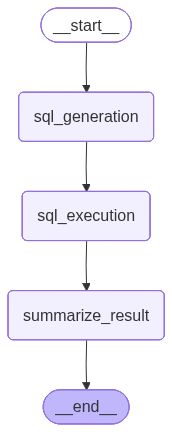

In [146]:
simple_workflow = StateGraph(AgentState)

simple_workflow.add_node("sql_generation", sql_generation_node)
simple_workflow.add_node("sql_execution", sql_node)
simple_workflow.add_node("summarize_result", summarize_result_node)

simple_workflow.set_entry_point("sql_generation")
simple_workflow.add_edge("sql_generation", "sql_execution")
simple_workflow.add_edge("sql_execution", "summarize_result")
simple_workflow.add_edge("summarize_result", END)

app = simple_workflow.compile()
app

In [147]:
user_question = "Какие классы заболеваний наиболее распространены в Петроградском районе среди пациентов старше 60 лет?"
initial_state = {"messages": [HumanMessage(content=user_question)], "user_query": user_question}
final_state = app.invoke(initial_state)

In [159]:
execute_sql_query("""SELECT 
    column_name, 
    data_type, 
    is_nullable, 
    column_default 
FROM information_schema.columns 
WHERE table_name = 'patients' 
  AND column_name = 'birth_date';""")

'[{"column_name":"birth_date","data_type":"text","is_nullable":"YES","column_default":null}]'

In [149]:
print(final_state["summary"])

Ошибка в SQL запросе связана с тем, что вы пытаетесь вычесть текст из даты: `CURRENT_DATE - p.birth_date`. В PostgreSQL такая операция не поддерживается, потому что `birth_date` — это текст (строка), а не дата.

### Резюме ошибки для пользователя:
> **Ошибка:** Невозможно вычесть текст из даты.  
> **Причина:** В запросе используется поле `birth_date`, которое хранится как текст, а не как дата. Система не может выполнить операцию вычитания даты из текста.

### Что нужно сделать:
- Привести поле `birth_date` к типу `date` с помощью явного преобразования (например, `CAST(p.birth_date AS DATE)` или `p.birth_date::DATE`).
- Убедиться, что данные в `birth_date` представлены в правильном формате (например, `YYYY-MM-DD`).

### Пример исправленного запроса:
```sql
SELECT 
    p.disease_class,
    COUNT(*) AS count
FROM patients p
WHERE 
    p.residential_area = 'ПЕТРОГРАДСКИЙ' 
    AND (CURRENT_DATE - CAST(p.birth_date AS DATE)) > INTERVAL '60 years'
GROUP BY p.disease_class
ORDER BY count DES

## Agent

In [27]:
class SubTask(TypedDict):
    id: int
    description: str
    status: Literal["pending", "in_progress", "completed", "failed"]
    result: dict | None


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    initial_task: str
    needs_decomposition: bool | None
    subtasks: list[SubTask]
    current_subtask_id: int | None
    # all_tasks_complete: bool
    # final_summary: dict | None


class RouterDecision(BaseModel):
    needs_decomposition: bool = Field(description="Требуется ли разбиение на подзадачи")
    reason: str = Field(description="Краткое объяснение решения")


class SubTaskSchema(BaseModel):
    id: int = Field(description="ID подзадачи")
    description: str = Field(description="Описание подзадачи")
    depends_on: list[int] | None = Field(
        default=None, description="ID подзадач, от которых зависит эта (опционально)"
    )


class TaskPlan(BaseModel):
    subtasks: list[SubTaskSchema] = Field(description="Список подзадач")
    reasoning: str = Field(description="Объяснение плана декомпозиции")

In [28]:
def router_node(state: AgentState):
    messages = state["messages"]
    initial_task = state.get("initial_task", messages[-1].content)
    router_prompt = ROUTER_PROMPT_TEMPLATE.format(initial_task=initial_task, ddl_schema=DDL_SCHEMA)

    llm_structured = llm.with_structured_output(RouterDecision)

    try:
        decision = llm_structured.invoke([SystemMessage(content=router_prompt)])

        print(f"Router: needs_decomposition={decision.needs_decomposition}")
        print(f"Reason: {decision.reason}")

        if decision.needs_decomposition:
            return {
                "needs_decomposition": True,
                "messages": [AIMessage(content=f"Декомпозиция нужна:\n{decision.reason}")],
            }

        subtasks = [
            SubTask(id=1, description=initial_task, status="pending", result=None, error=None)
        ]
        state["subtasks"] = subtasks
        state["current_subtask_id"] = 1

        return {
            "needs_decomposition": False,
            "subtasks": subtasks,
            "current_subtask_id": 1,
            "messages": [AIMessage(content=f"Декомпозиция НЕ нужна:\n{decision.reason}")],
        }

    except Exception as e:
        print(f"Router error: {e}")

        subtasks = [
            SubTask(id=1, description=initial_task, status="pending", result=None, error=None)
        ]
        state["subtasks"] = subtasks
        state["current_subtask_id"] = 1

        return {
            "needs_decomposition": False,
            "subtasks": subtasks,
            "current_subtask_id": 1,
            "messages": [AIMessage(content=f"Декомпозиция НЕ нужна:\n{decision.reason}")],
        }

In [29]:
def planning_node(state: AgentState):
    initial_task = state.get("initial_task", state["messages"][-1].content)

    planning_prompt = DECOMPOSITION_PROMPT_TEMPLATE.format(
        initial_task=initial_task, ddl_schema=DDL_SCHEMA
    )

    llm_structured = llm.with_structured_output(TaskPlan)

    try:
        plan = llm_structured.invoke([SystemMessage(content=planning_prompt)])

        print(f"Plan created with {len(plan.subtasks)} subtasks")
        print(f"Reasoning: {plan.reasoning}")

        subtasks = [
            SubTask(
                id=task.id, description=task.description, status="pending", result=None, error=None
            )
            for task in plan.subtasks
        ]

        for task in plan.subtasks:
            deps = f" (depends on: {task.depends_on})" if task.depends_on else ""
            print(f"{task.id}. {task.description}{deps}")

        return {
            "subtasks": subtasks,
            "current_subtask_id": 1,
            "messages": [AIMessage(content=f"План создан:\n{plan.reasoning}")],
        }

    except Exception as e:
        print(f"Planning error: {e}")

        return {
            "subtasks": [
                SubTask(id=1, description=task, status="pending", result=None, error=None)
            ],
            "current_subtask_id": 1,
            "messages": [
                AIMessage(content="Не удалось декомпозировать. Выполняю как одну задачу.")
            ],
        }


def route_after_router_test(state: AgentState) -> str:
    if state.get("needs_decomposition"):
        return "planning_node"
    return END

In [30]:
@tool
def execute_sql(sql_query: str, max_rows: int = 200) -> str:
    """
    Execute SQL against PostgreSQL using DB_CONFIG.
    - SELECT -> returns CSV of up to `max_rows` rows (notes if truncated)
    - other -> commits and returns rows affected
    """
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        cur = conn.cursor()
        cur.execute(sql_query)

        # If cursor.description is present -> query returned columns (SELECT, etc.)
        if cur.description:
            cols = [desc[0] for desc in cur.description]
            rows = cur.fetchmany(max_rows + 1)
            df = pd.DataFrame(rows, columns=cols)
            if df.empty:
                return "Query executed successfully — no rows returned."
            truncated_note = ""
            if len(rows) > max_rows:
                df = df.iloc[:max_rows]
                truncated_note = (
                    f"\n...returned more than {max_rows} rows; showing first {max_rows} rows..."
                )
            return df.to_json(index=False) + truncated_note

        # Non-SELECT: commit and report affected rows
        conn.commit()
        return f"Query executed successfully: {cur.rowcount} rows affected."

    except psycopg2.Error as e:
        if conn:
            conn.rollback()
        # concise DB error
        msg = getattr(e, "pgerror", str(e))
        return f"Database error: {msg}"
    except Exception as e:
        return f"Unexpected error: {e}"
    finally:
        if conn:
            conn.close()